# **RNN From Scratch in Python**
*By Cristian Leo*

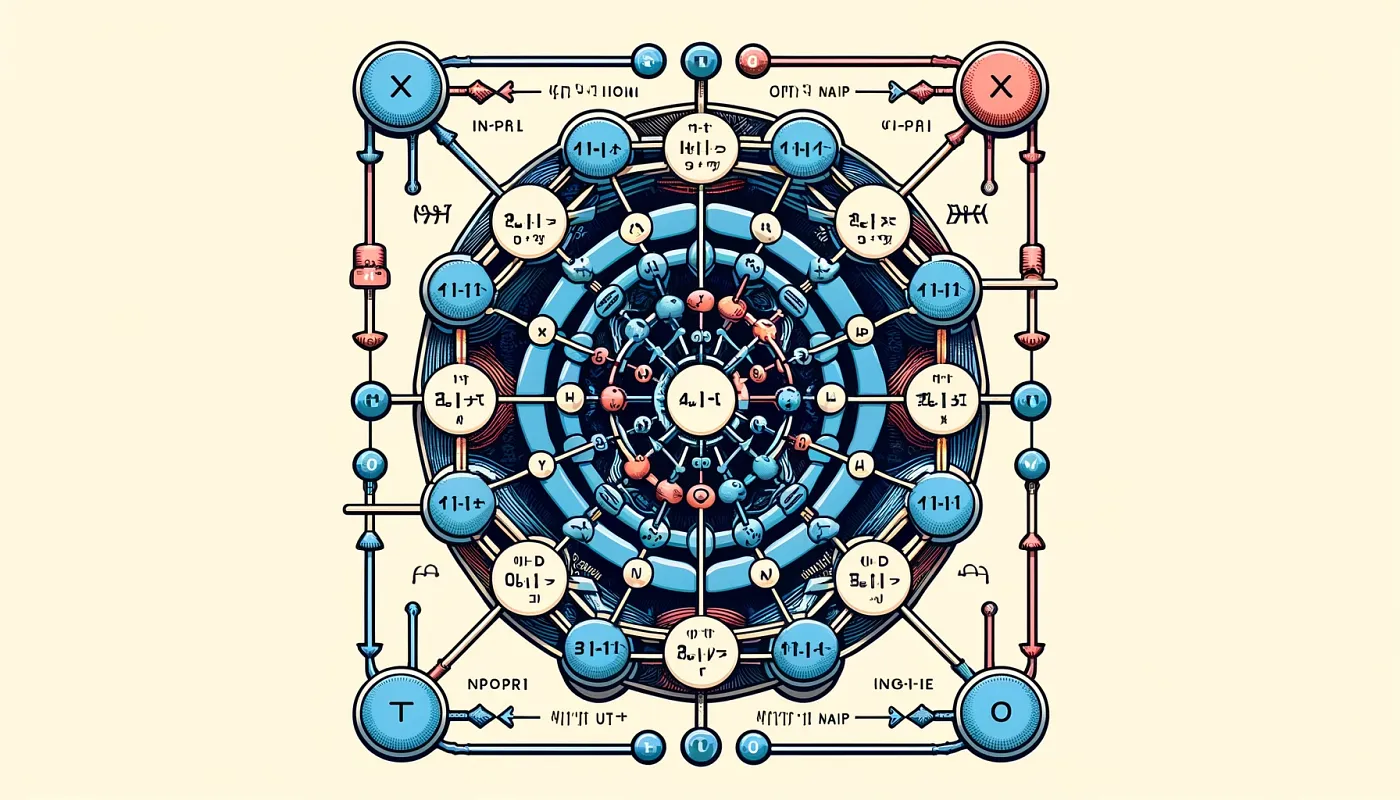

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class RNN:
    """
    A simple RNN implementation.

    Args:
        input_size (int): The size of the input vectors.
        hidden_size (int): The size of the hidden layer.
        output_size (int): The size of the output vectors.
    """
    def __init__(self, input_size, hidden_size, output_size, init_method="random"):
        self.weights_ih, self.weights_hh, self.weights_ho = self.initialize_weights(input_size, hidden_size, output_size, init_method)
        self.bias_h = np.zeros((1, hidden_size))
        self.bias_o = np.zeros((1, output_size))
        self.hidden_size = hidden_size

    def initialize_weights(self, input_size, hidden_size, output_size, method):
        if method == "random":
            weights_ih = np.random.randn(input_size, hidden_size) * 0.01
            weights_hh = np.random.randn(hidden_size, hidden_size) * 0.01
            weights_ho = np.random.randn(hidden_size, output_size) * 0.01
        elif method == "xavier":
            weights_ih = np.random.randn(input_size, hidden_size) / np.sqrt(input_size / 2)
            weights_hh = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size / 2)
            weights_ho = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size / 2)
        elif method == "he":
            weights_ih = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
            weights_hh = np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / hidden_size)
            weights_ho = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
        else:
            raise ValueError("Invalid initialization method")
        return weights_ih, weights_hh, weights_ho


    def forward(self, inputs):
        """
        Perform a forward pass through the RNN.
        
        Args:
            inputs (list): A list of input vectors.
        
        Returns:
            np.ndarray: The output vector.
        """
        h = np.zeros((1, self.hidden_size))
        self.last_inputs = inputs
        self.last_hs = {0: h}

        for i, x in enumerate(inputs):
            x = x.reshape(1, -1)  # Ensure x is a row vector
            h = np.tanh(np.dot(x, self.weights_ih) + np.dot(h, self.weights_hh) + self.bias_h)
            self.last_hs[i + 1] = h

        y = np.dot(h, self.weights_ho) + self.bias_o
        self.last_outputs = y
        return y

    def backprop(self, d_y, learning_rate, clip_value=1):
        """
        Perform backpropagation through time.

        Args:
            d_y (np.ndarray): The gradient of the loss with respect to the output.
            learning_rate (float): The learning rate.
        """
        n = len(self.last_inputs)

        d_y_pred = (self.last_outputs - d_y) / d_y.size
        d_Whh = np.zeros_like(self.weights_hh)
        d_Wxh = np.zeros_like(self.weights_ih)
        d_Why = np.zeros_like(self.weights_ho)
        d_bh = np.zeros_like(self.bias_h)
        d_by = np.zeros_like(self.bias_o)
        d_h = np.dot(d_y_pred, self.weights_ho.T)

        for t in reversed(range(1, n + 1)):
            d_h_raw = (1 - self.last_hs[t] ** 2) * d_h
            d_bh += d_h_raw
            d_Whh += np.dot(self.last_hs[t - 1].T, d_h_raw)
            d_Wxh += np.dot(self.last_inputs[t - 1].reshape(1, -1).T, d_h_raw)
            d_h = np.dot(d_h_raw, self.weights_hh.T)

        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            np.clip(d, -clip_value, clip_value, out=d)
            
        self.weights_ih -= learning_rate * d_Wxh
        self.weights_hh -= learning_rate * d_Whh
        self.weights_ho -= learning_rate * d_Why
        self.bias_h -= learning_rate * d_bh
        self.bias_o -= learning_rate * d_by

In [3]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after

    Args:
    -----
        patience (int): Number of epochs to wait before stopping the training.
        verbose (bool): If True, prints a message for each epoch where the loss
                        does not improve.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
    """
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        """
        Determines if the model should stop training.
        
        Args:
            val_loss (float): The loss of the model on the validation set.
        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [4]:
class RNNTrainer:
    """
    A class to train an RNN model.

    Args:
        model (RNN): The RNN model to train.
        loss_func (str): The loss function to use.
    """
    def __init__(self, model, loss_func='mse'):
        self.model = model
        self.loss_func = loss_func
        self.train_loss = []
        self.val_loss = []

    def calculate_loss(self, y_true, y_pred):
        """
        Calculate the loss.

        Parameters:
        -----------
        y_true: numpy array
            The true output
        y_pred: numpy array
            The predicted output
        
        Returns:
        --------
        float
            The loss
        """
        if self.loss_func == 'mse':
            return np.mean((y_pred - y_true)**2)
        
        elif self.loss_func == 'log_loss':
            return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))
        
        elif self.loss_func == 'categorical_crossentropy':
            return -np.mean(y_true*np.log(y_pred))
        
        else:
            raise ValueError('Invalid loss function')

    def train(self, train_data, train_labels, val_data, val_labels, epochs, learning_rate, early_stopping=True, patience=10, clip_value=1):
        """
        Train the model.

        Args:
            train_data (list): A list of training data.
            train_labels (list): A list of training labels.
            val_data (list): A list of validation data.
            val_labels (list): A list of validation labels.
            epochs (int): The number of epochs to train for.
            learning_rate (float): The learning rate.
            early_stopping (bool): Whether to use early stopping.
            patience (int): The number of epochs to wait before stopping the training.
        """
        if early_stopping:
            early_stopping = EarlyStopping(patience=patience, verbose=True)
        for epoch in range(epochs):
            for X_train, y_train in zip(train_data, train_labels):
                outputs = self.model.forward(X_train)
                self.model.backprop(y_train, learning_rate, clip_value)
                train_loss = self.calculate_loss(y_train, outputs)
                self.train_loss.append(train_loss)

            val_loss_epoch = []
            for X_val, y_val in zip(val_data, val_labels):
                val_outputs = self.model.forward(X_val)
                val_loss = self.calculate_loss(y_val, val_outputs)
                val_loss_epoch.append(val_loss)

            val_loss = np.mean(val_loss_epoch)
            self.val_loss.append(val_loss)

            if early_stopping:
                early_stopping(val_loss)

                if early_stopping.early_stop:
                    print(f"Early stopping at epoch {epoch} | Best validation loss = {-early_stopping.best_score:.3f}")
                    break

            if epoch % 5 == 0:
                print(f'Epoch {epoch}: Train loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}')

In [5]:
class TimeSeriesDataset:
    def __init__(self, url, look_back=1, train_size=0.67):
        self.url = url
        self.look_back = look_back
        self.train_size = train_size

    def load_data(self):
        df = pd.read_csv(self.url, usecols=[1])
        df = self.MinMaxScaler(df.values)  # Convert DataFrame to numpy array
        train_size = int(len(df) * self.train_size)
        train, test = df[0:train_size,:], df[train_size:len(df),:]
        return train, test
    
    def MinMaxScaler(self, data):
        numerator = data - np.min(data, 0)
        denominator = np.max(data, 0) - np.min(data, 0)
        return numerator / (denominator + 1e-7)

    def create_dataset(self, dataset):
        dataX, dataY = [], []
        for i in range(len(dataset)-self.look_back-1):
            a = dataset[i:(i+self.look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + self.look_back, 0])
        return np.array(dataX), np.array(dataY)

    def get_train_test(self):
        train, test = self.load_data()
        trainX, trainY = self.create_dataset(train)
        testX, testY = self.create_dataset(test)
        return trainX, trainY, testX, testY

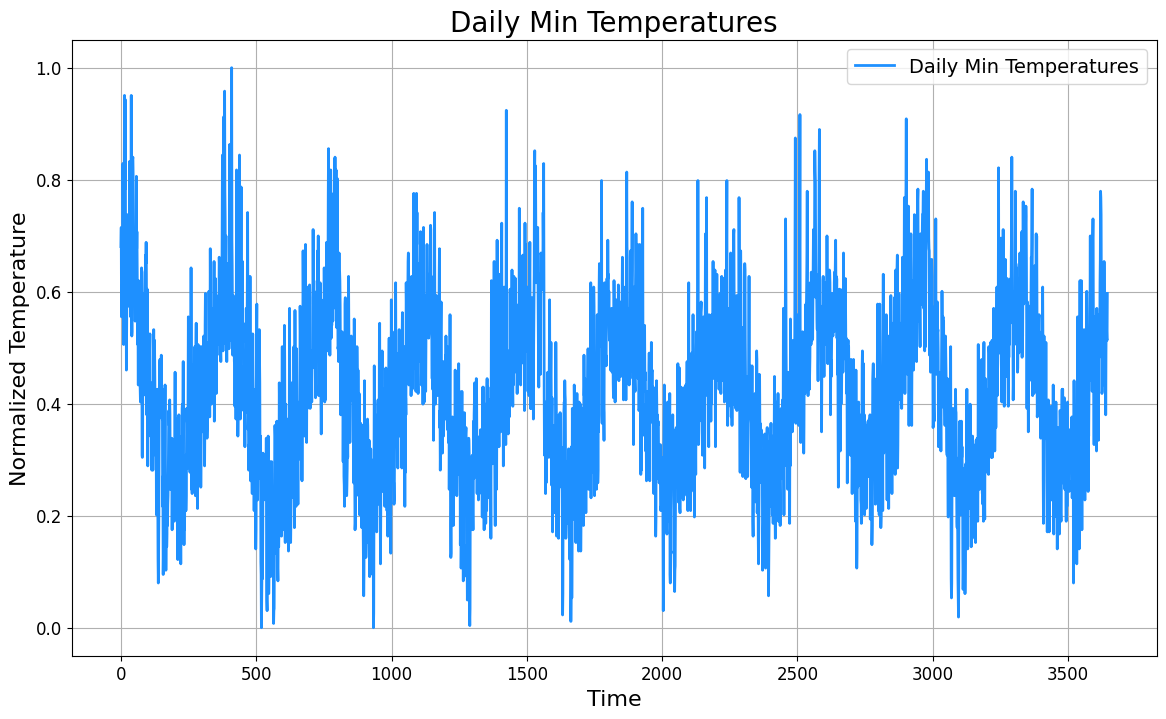

In [6]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
dataset = TimeSeriesDataset(url, look_back=1)
trainX, trainY, testX, testY = dataset.get_train_test()

# Combine train and test data
combined = np.concatenate((trainY, testY))

# Plot the data
plt.figure(figsize=(14, 8))
plt.plot(combined, label='Daily Min Temperatures', linewidth=2, color='dodgerblue')
plt.title('Daily Min Temperatures', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Normalized Temperature', fontsize=16)
plt.grid(True)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [7]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

look_back = 1

# Create and train the RNN
rnn = RNN(look_back, 256, 1, init_method='xavier')
trainer = RNNTrainer(rnn, 'mse')
trainer.train(trainX, trainY, testX, testY, epochs=100, learning_rate=1e-3, early_stopping=True, patience=10, clip_value=1)

Epoch 0: Train loss = 0.0015, Validation loss = 0.0245
Epoch 5: Train loss = 0.0000, Validation loss = 0.0167
Epoch 10: Train loss = 0.0003, Validation loss = 0.0141
Epoch 15: Train loss = 0.0008, Validation loss = 0.0130
Epoch 20: Train loss = 0.0012, Validation loss = 0.0126
Epoch 25: Train loss = 0.0014, Validation loss = 0.0123
Epoch 30: Train loss = 0.0015, Validation loss = 0.0121
Epoch 35: Train loss = 0.0016, Validation loss = 0.0119
Epoch 40: Train loss = 0.0016, Validation loss = 0.0118
Epoch 45: Train loss = 0.0016, Validation loss = 0.0117
Epoch 50: Train loss = 0.0017, Validation loss = 0.0116
Epoch 55: Train loss = 0.0017, Validation loss = 0.0115
Epoch 60: Train loss = 0.0017, Validation loss = 0.0114
Epoch 65: Train loss = 0.0017, Validation loss = 0.0113
Epoch 70: Train loss = 0.0017, Validation loss = 0.0112
Epoch 75: Train loss = 0.0017, Validation loss = 0.0111
Epoch 80: Train loss = 0.0017, Validation loss = 0.0111
Epoch 85: Train loss = 0.0017, Validation loss = 0